In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import scipy
import astropy
import tqdm

## Load data

In [4]:
def data_scope(arr, t_arr, t_start, t_stop):
    idxs = np.where((t_arr >= t_start) & (t_arr <= t_stop))[0]
    return arr[idxs]

def spike_scope(spikes, t_arr):
    hists = []
    for spike_train in spikes.item().values():
        hist, _ = np.histogram(spike_train, bins=np.append(t_arr, t_arr[-1] + t_arr[1] - t_arr[0]))
        hists.append(hist)
    hists = np.array(hists)
    return hists

In [5]:
data_path = '/Users/vemundss/Desktop/Toroidal_topology_grid_cell_data/'

In [6]:
with open(data_path + 'rat_q_sessions.txt') as file:
#with open(data_path + 'rat_r_day1_sessions.txt') as file:
#with open(data_path + 'rat_r_day2_sessions.txt') as file:
#with open(data_path + 'rat_s_sessions.txt') as file:
    sessions = file.readlines()
sessions

['#1,  sleep_box_1,        start=9576, end=18812   \n',
 '#2,  wagon_wheel_1,      start=18977, end=25355   \n',
 '#3,  sleep_box_2,        start=25403, end=27007   \n',
 '#4,  open_field_1,       start=27826, end=31223   \n']

In [7]:
data = {}

In [8]:
f = np.load(data_path + 'rat_q_grid_modules_1_2.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']

t_start, t_stop = 27826, 31223
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)

data['rat_q'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2}}

In [9]:
f = np.load(data_path + 'rat_r_day1_grid_modules_1_2_3.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']
spikes3 = f['spikes_mod3']

t_start, t_stop = 7457, 14778
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)
spikes3 = spike_scope(f['spikes_mod3'], t)

data['rat_r_day1'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2, 3: spikes3}}

# can add second slice (valid times) 14890, 16045 here

In [10]:
f = np.load(data_path + 'rat_r_day2_grid_modules_1_2_3.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']
spikes3 = f['spikes_mod3']

t_start, t_stop = 10617, 13004
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)
spikes3 = spike_scope(f['spikes_mod3'], t)

data['rat_r_day2'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2, 3: spikes3}}

In [11]:
f = np.load(data_path + 'rat_s_grid_modules_1.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']

t_start, t_stop = 9939, 12363
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)

data['rat_s'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1}}

## Create ratemaps

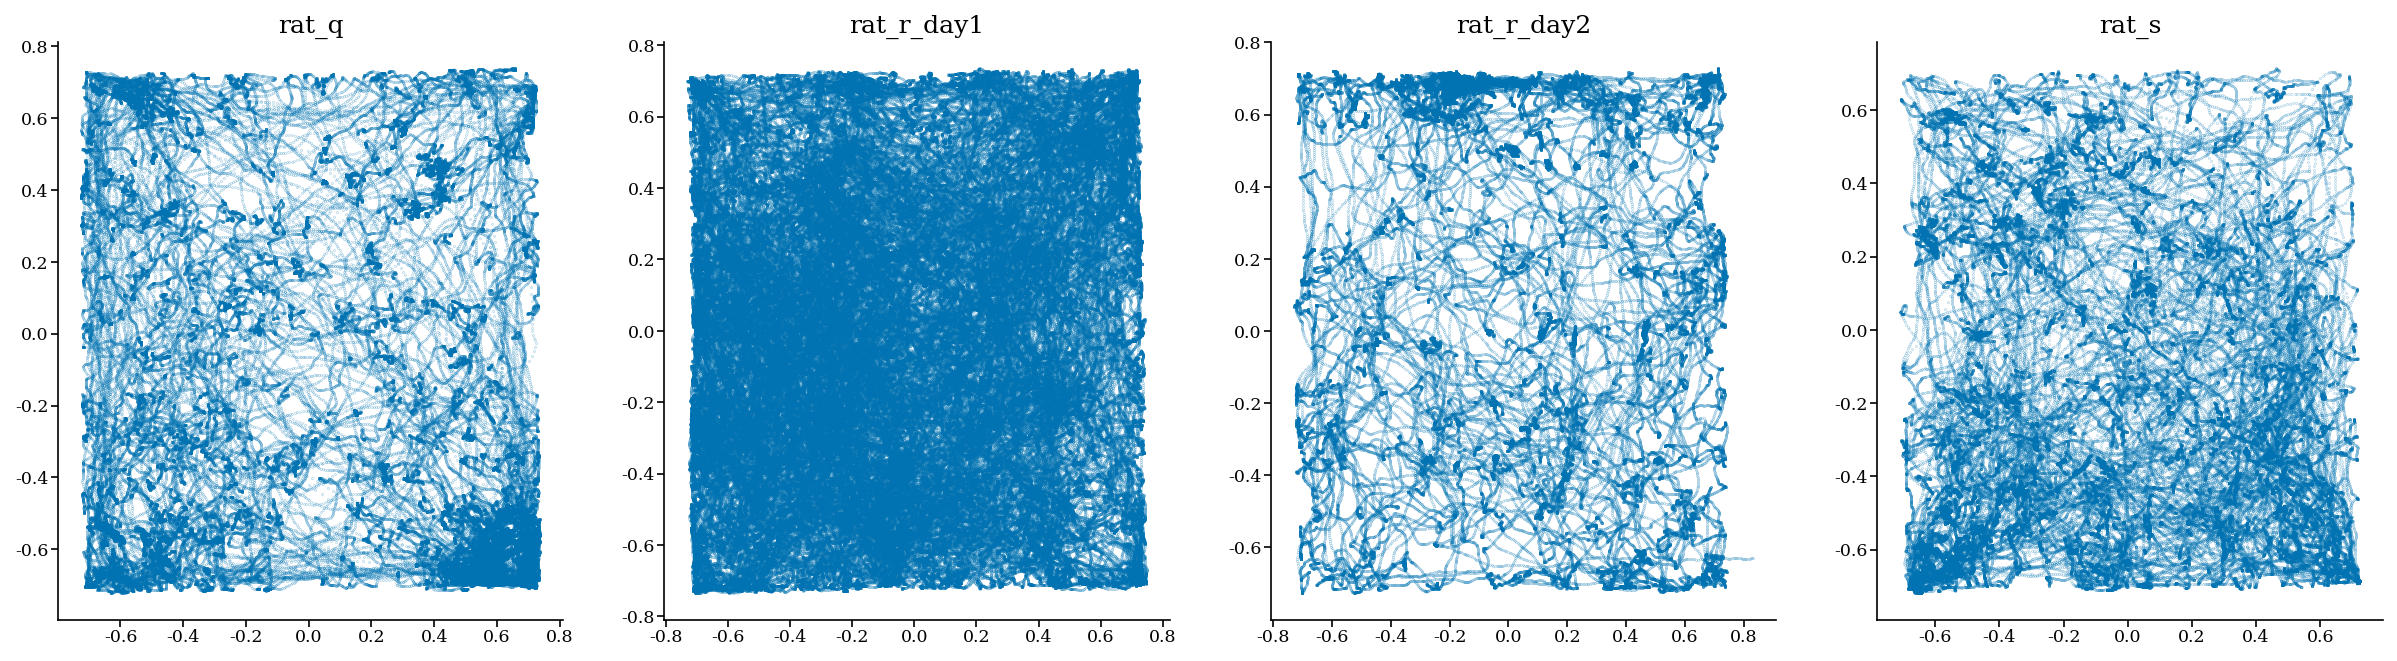

In [12]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
for i, (rat, rat_data) in enumerate(data.items()):
    axs[i].scatter(rat_data['x'], rat_data['y'], s=0.01)
    axs[i].set_title(rat)

In [13]:
import spatial_maps as sm
res = 32
grid_threshold = 0.4 # <----------------- threshold for gridness score
all_ratemaps = []
for rat_i, data_i in data.items():
    x, y = data_i['x'], data_i['y']
    for module_j, spikes_j in data_i['modules'].items():
        ratemaps_ij = scipy.stats.binned_statistic_2d(x, y, spikes_j, bins=res).statistic
        ratemaps_ij = np.array([astropy.convolution.convolve(ratemap, astropy.convolution.Gaussian2DKernel(2), boundary='wrap') 
                                for ratemap in ratemaps_ij])
        grid_scores = np.array([sm.gridness(ratemap) for ratemap in ratemaps_ij])
        mask = grid_scores > grid_threshold
        ratemaps_ij = ratemaps_ij[mask]
        all_ratemaps.append(ratemaps_ij)
        print(rat_i, module_j, len(ratemaps_ij), len(grid_scores))

rat_q 1 74 97
rat_q 2 33 66
rat_r_day1 1 126 166
rat_r_day1 2 114 168
rat_r_day1 3 23 149
rat_r_day2 1 140 189
rat_r_day2 2 124 172
rat_r_day2 3 19 183
rat_s 1 123 140


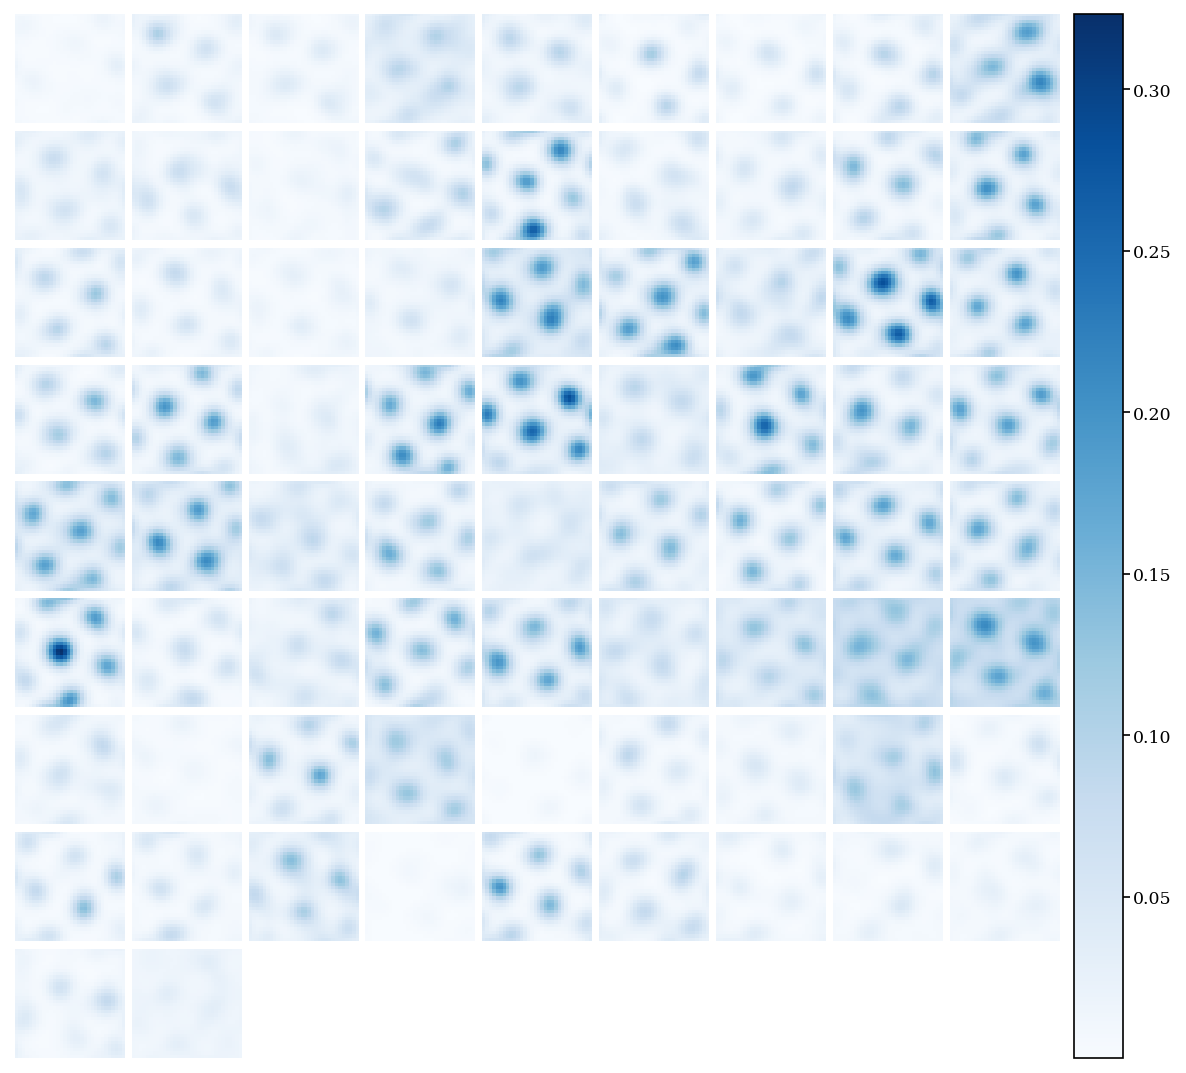

In [14]:
from plotting_functions import multiimshow
multiimshow(all_ratemaps[0], figsize=(8,8));

In [15]:
def metric_components_from_ratemaps(ratemaps):
    grads = np.array([np.gradient(im) for im in ratemaps])
    grads = np.transpose(grads, (0, -2, -1, 1))
    grads = grads[:, 1:-1, 1:-1] # remove 1st order boundary term

    m11 = np.mean(grads[...,0]**2, axis = 0)
    m22 = np.mean(grads[...,1]**2, axis = 0)
    m12 = np.mean(grads[...,0]*grads[...,1], axis = 0)
    return m11, m22, m12

def CIS(m11, m22, m12):
    return np.var(m11) + np.var(m22) + np.mean((m11-m22)**2) + 2*np.mean(m12**2)

In [16]:
data_cis = [CIS(*metric_components_from_ratemaps(ratemaps)) for ratemaps in all_ratemaps]

phase_clustered_cis = []
phase_shuffled_cis = []
space_shuffled_cis = []
for ratemaps in all_ratemaps[2:]:
    center_peaks = np.array([sm.find_peaks(ratemap)[0] for ratemap in ratemaps])
    phase_clustered_maps = np.copy(ratemaps)
    phase_shuffled_maps = np.copy(ratemaps)
    space_shuffled_maps = np.copy(ratemaps).reshape(-1, res*res)

    phase_clustered_maps = np.array([np.roll(phase_clustered_maps[i], -(center_peaks[i] - res//2), axis = (-2, -1)) for i in range(len(ratemaps))])
    phase_shuffled_maps = np.array([np.roll(phase_shuffled_maps[i], np.random.randint(res, size = 2), axis = (-2, -1)) for i in range(len(ratemaps))])
    inds = np.random.choice(res*res, size = res*res, replace = False)
    space_shuffled_maps = space_shuffled_maps[:, inds]
    space_shuffled_maps = np.reshape(space_shuffled_maps, (-1, res, res))
    
    phase_clustered_cis.append(CIS(*metric_components_from_ratemaps(phase_clustered_maps)))
    phase_shuffled_cis.append(CIS(*metric_components_from_ratemaps(phase_shuffled_maps)))
    space_shuffled_cis.append(CIS(*metric_components_from_ratemaps(space_shuffled_maps)))

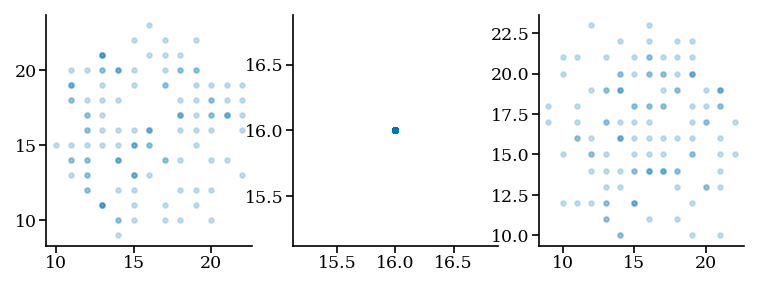

In [17]:
fig,axs=plt.subplots(ncols=3, figsize=(6,2))
center_peaks2 = np.array([sm.find_peaks(ratemap)[0] for ratemap in phase_clustered_maps])
center_peaks3 = np.array([sm.find_peaks(ratemap)[0] for ratemap in phase_shuffled_maps])
axs[0].scatter(*center_peaks.T, s=5,alpha=0.2)
axs[1].scatter(*center_peaks2.T, s=5,alpha=0.2)
axs[2].scatter(*center_peaks3.T, s=5,alpha=0.2)

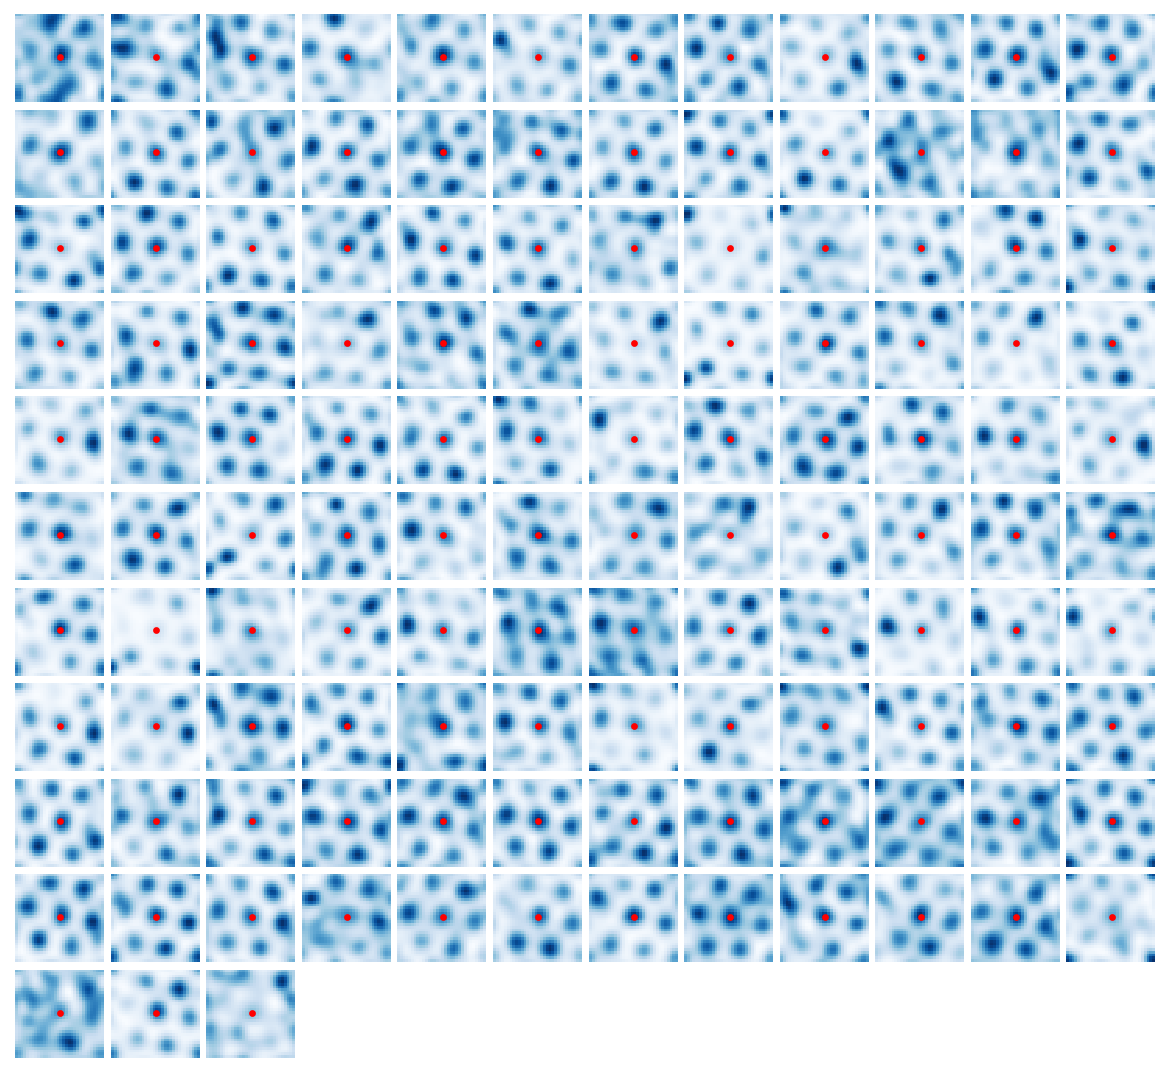

In [18]:
from plotting_functions import multiimshow
fig, axs = multiimshow(phase_clustered_maps.transpose(0,2,1), figsize=(8,8), normalize=False, origin='lower');
for i in range(len(phase_clustered_maps)):
    axs[i].scatter(*center_peaks2[i], s=5, c='r')

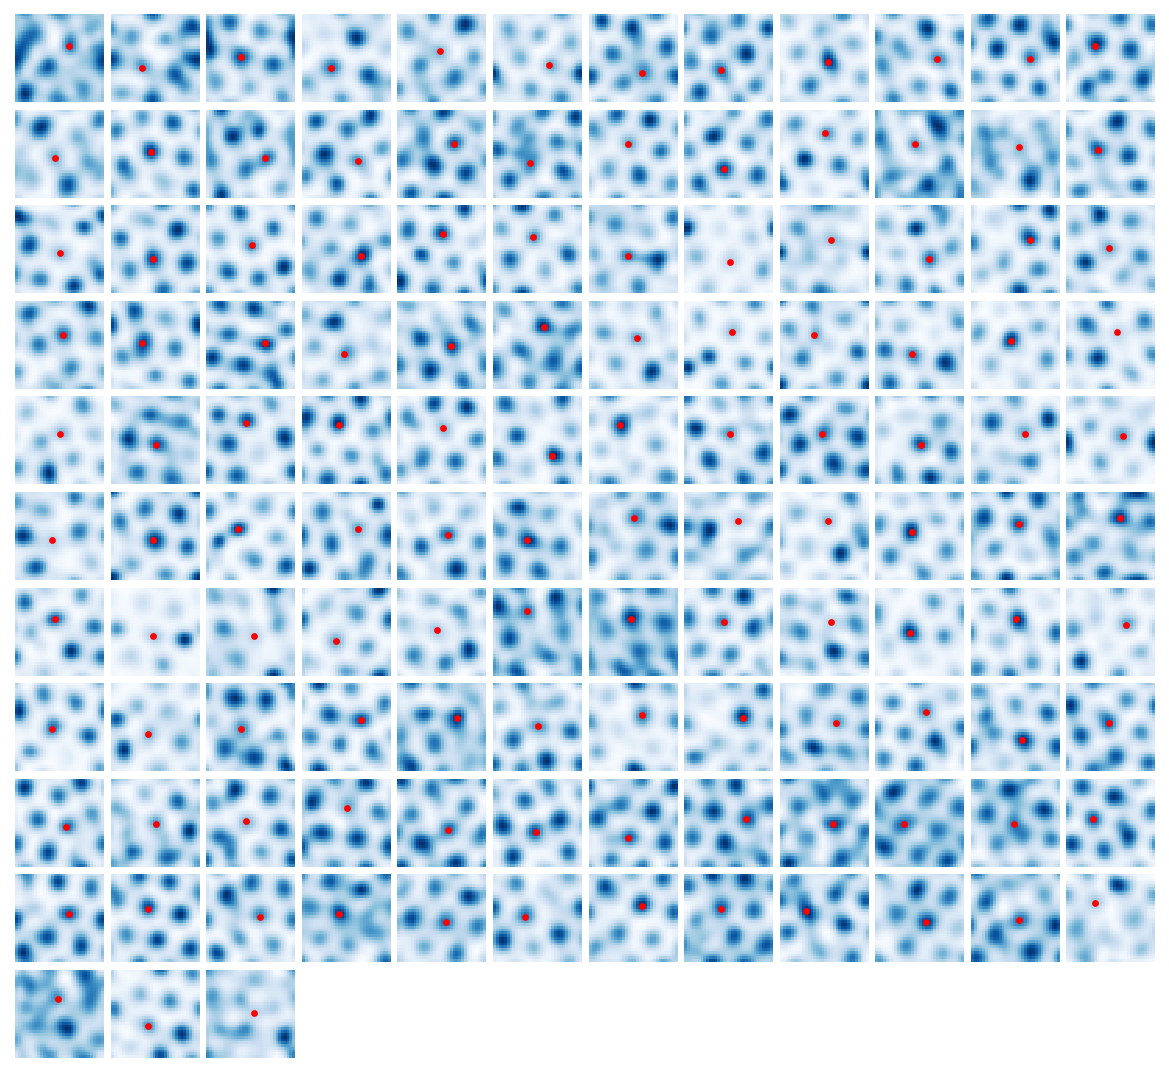

In [19]:
from plotting_functions import multiimshow
fig, axs = multiimshow(phase_shuffled_maps.transpose(0,2,1), figsize=(8,8), normalize=False, origin='lower');
for i in range(len(phase_shuffled_maps)):
    axs[i].scatter(*center_peaks3[i], s=5, c='r')

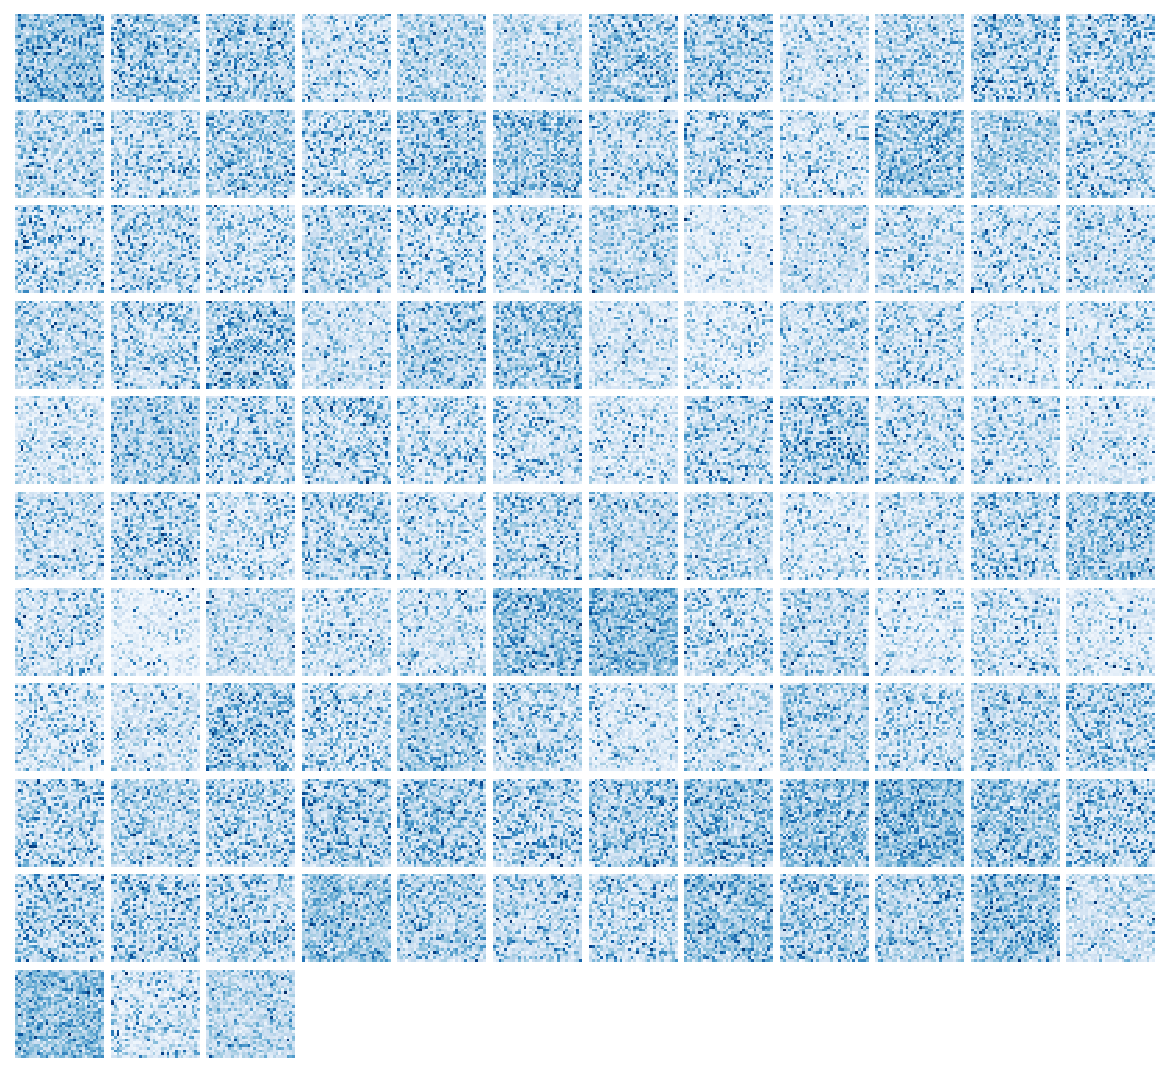

In [20]:
from plotting_functions import multiimshow
fig, axs = multiimshow(space_shuffled_maps.transpose(0,2,1), figsize=(8,8), normalize=False, origin='lower');

(array([1, 2, 3, 4]),
 [Text(1, 0, 'data'),
  Text(2, 0, 'phase shuffled'),
  Text(3, 0, 'phase clustered'),
  Text(4, 0, 'space shuffled')])

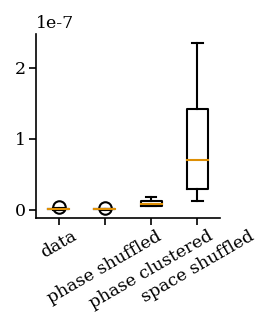

In [21]:
plt.boxplot([data_cis, phase_shuffled_cis, phase_clustered_cis, space_shuffled_cis], 
            labels=['data', 'phase shuffled', 'phase clustered', 'space shuffled']);
plt.xticks(rotation=30)

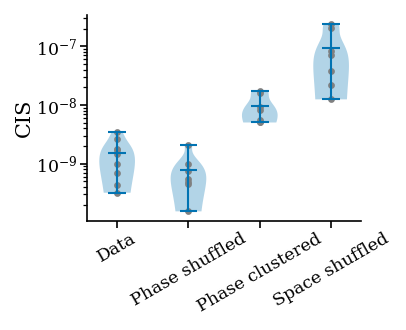

In [22]:
fig, ax = plt.subplots(figsize=(2.5,2))
ax.violinplot([data_cis, phase_shuffled_cis, phase_clustered_cis, space_shuffled_cis], showmeans=True)
ax.scatter(np.ones(len(data_cis)), data_cis, color='grey', s=5)
ax.scatter(np.ones(len(phase_shuffled_cis))*2, phase_shuffled_cis, color='grey', s=5)
ax.scatter(np.ones(len(phase_clustered_cis))*3, phase_clustered_cis, color='grey', s=5)
ax.scatter(np.ones(len(space_shuffled_cis))*4, space_shuffled_cis, color='grey', s=5)
ax.set_xticks([1, 2, 3, 4])
ax.xaxis.set_tick_params(rotation=30)
ax.set_xticklabels(['Data', 'Phase shuffled', 'Phase clustered', 'Space shuffled'])
ax.set_ylabel('CIS')
# make y axis logarithmic
ax.set_yscale('log')

fig.tight_layout(pad=0)
fig.savefig('./results/experimental-cis.pdf', bbox_inches='tight')

In [23]:
# Mann-Whitney U test
from scipy.stats import mannwhitneyu
print("data -> phase shuffled", mannwhitneyu(data_cis, phase_shuffled_cis))
print("data -> phase clustered", mannwhitneyu(data_cis, phase_clustered_cis))
print("data -> space shuffled", mannwhitneyu(data_cis, space_shuffled_cis))
print("phase shuffled -> phase clustered", mannwhitneyu(phase_shuffled_cis, phase_clustered_cis))
print("phase shuffled -> space shuffled", mannwhitneyu(phase_shuffled_cis, space_shuffled_cis))
print("phase clustered -> space shuffled", mannwhitneyu(phase_clustered_cis, space_shuffled_cis))

data -> phase shuffled MannwhitneyuResult(statistic=43.0, pvalue=0.2522727272727273)
data -> phase clustered MannwhitneyuResult(statistic=0.0, pvalue=0.00017482517482517483)
data -> space shuffled MannwhitneyuResult(statistic=0.0, pvalue=0.00017482517482517483)
phase shuffled -> phase clustered MannwhitneyuResult(statistic=0.0, pvalue=0.0005827505827505828)
phase shuffled -> space shuffled MannwhitneyuResult(statistic=0.0, pvalue=0.0005827505827505828)
phase clustered -> space shuffled MannwhitneyuResult(statistic=2.0, pvalue=0.002331002331002331)


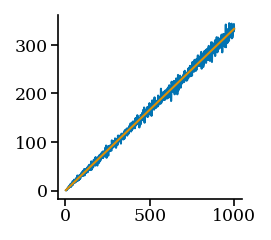

In [24]:
N = np.arange(3, 1000)
y = np.zeros(len(N))
for n in N:
    u = np.random.uniform(0, 1, n)
    y[n-3] = np.sum(u**2)

plt.plot(N, y)
plt.plot(N, N/3)

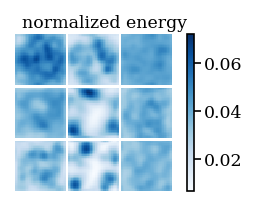

In [25]:
energy_maps = np.array([np.linalg.norm(ratemaps,axis=0) for ratemaps in all_ratemaps])
energy_maps_normalized = energy_maps / np.array([np.sqrt(len(ratemaps)) for ratemaps in all_ratemaps])[:,None,None]
fig, axs = multiimshow(energy_maps_normalized, figsize=(1.2,1.2), normalize=True, origin='lower', axes_pad=0.02)
#fig.tight_layout(pad=0)
# set title of figure
fig.suptitle('normalized energy', fontsize='small')
fig.savefig('./results/experimental-energy.pdf', bbox_inches='tight')

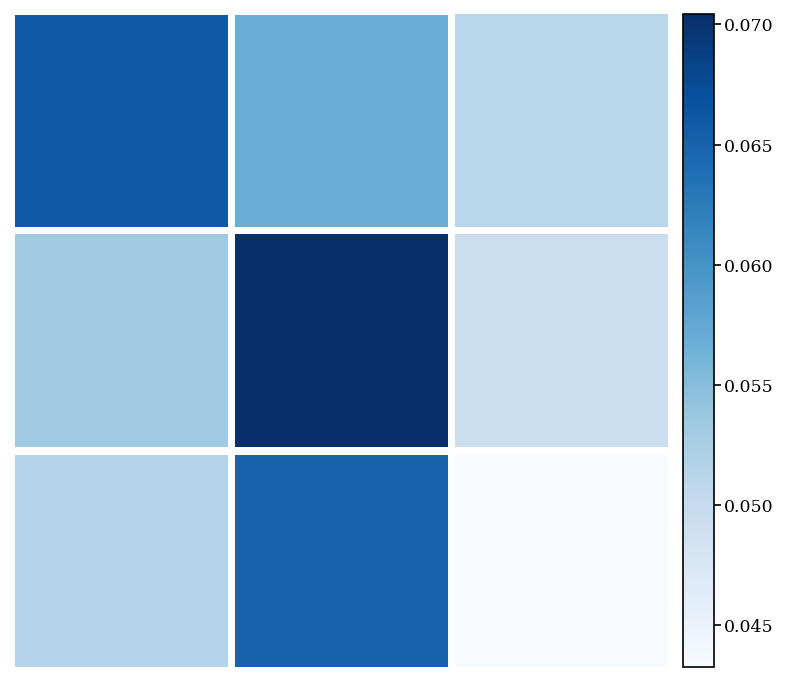

In [26]:
missing_energies = np.array([np.sqrt(energy_map.max()**2 - energy_map**2) for energy_map in energy_maps])
all_ratemaps_complete = [np.concatenate([ratemaps, missing_energy[None]], axis=0) for 
                         ratemaps, missing_energy in zip(all_ratemaps, missing_energies)]
#missing_energies = [energy_map.max() - energy_map for energy_map in energy_maps]
#all_ratemaps_complete = [ratemaps + missing_energy[None]
#                         for ratemaps, missing_energy in zip(all_ratemaps, missing_energies)]
energy_maps_complete = np.array([np.linalg.norm(ratemaps, axis=0) for ratemaps in all_ratemaps_complete])
energy_maps_normalized_complete = energy_maps_complete / np.array([np.sqrt(len(ratemaps)) for ratemaps in all_ratemaps_complete])[:,None,None]
multiimshow(energy_maps_normalized_complete, figsize=(5,5), normalize=True, origin='lower');

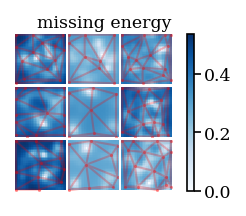

In [27]:
from scipy.spatial import Delaunay

energy_maps = np.array([np.linalg.norm(ratemaps,axis=0) for ratemaps in all_ratemaps])
energy_maps_normalized = energy_maps / np.array([np.sqrt(len(ratemaps)) for ratemaps in all_ratemaps])[:,None,None]
fig, axs = multiimshow(missing_energies, figsize=(1.2,1.2), normalize=True, origin='lower', axes_pad=0.02)
for i in range(len(energy_maps_normalized)):
    peaks = sm.find_peaks(missing_energies[i])
    axs[i].scatter(*peaks.T, c='r', alpha=0.4)
    tri = Delaunay(peaks)
    axs[i].triplot(peaks[:,0], peaks[:,1], tri.simplices, c='r', alpha=0.25)

fig.suptitle('missing energy', fontsize='small')
fig.savefig('./results/experimental-missing-energies.pdf', bbox_inches='tight')

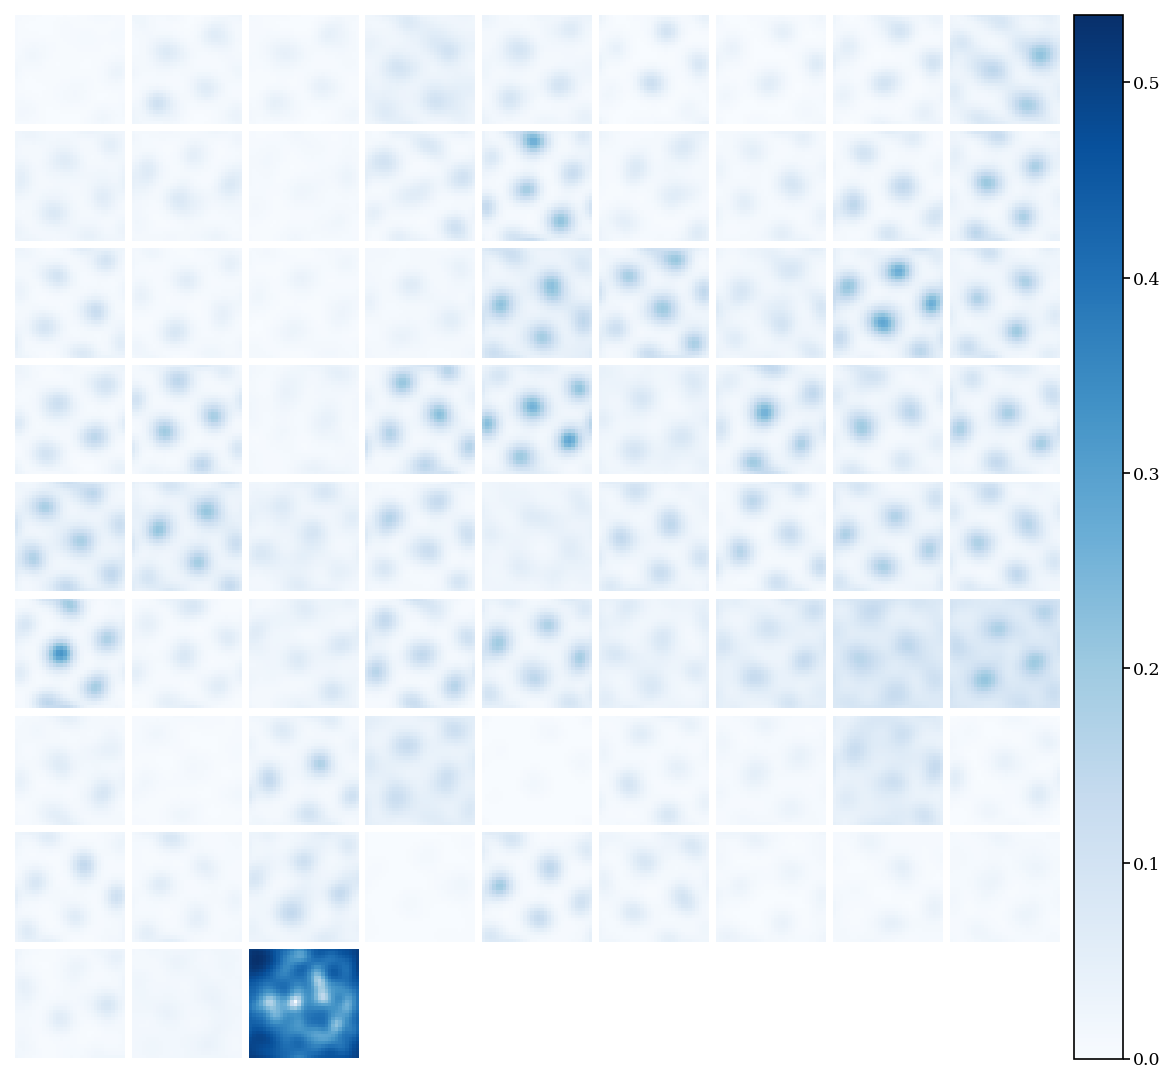

In [28]:
multiimshow(all_ratemaps_complete[0], figsize=(8,8), normalize=True, origin='lower');

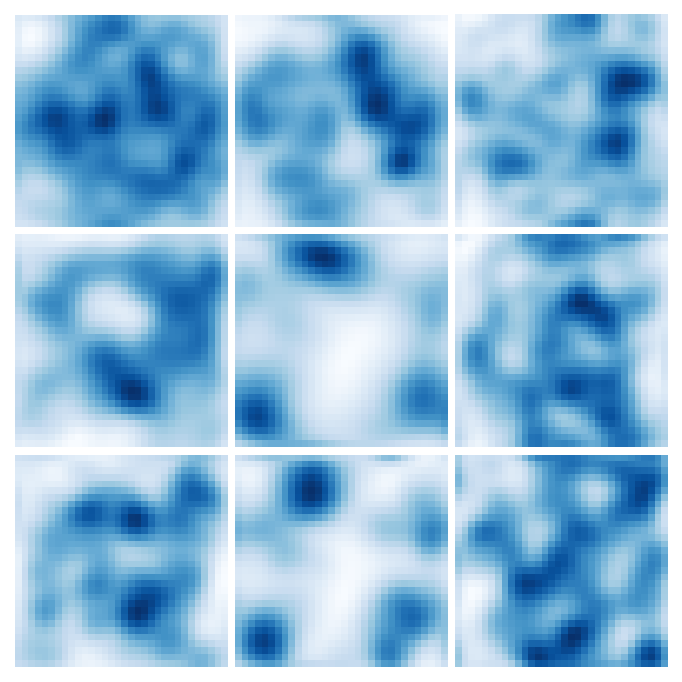

In [29]:
avg_firing_rate = [np.mean(ratemaps,axis=(1,2)) for ratemaps in all_ratemaps]
normalized_maps = []
for ratemaps, avg in zip(all_ratemaps, avg_firing_rate):
    probmaps = np.array([ratemap / np.sum(ratemap) for ratemap in ratemaps])
    avg_firing_rate = np.mean(probmaps, axis=(1,2))
    normalized_map = probmaps * avg_firing_rate[:,None,None]
    # clip 4 sigma outliers
    #normalized_map = np.clip(normalized_map, np.mean(normalized_map) - 1*np.std(normalized_map), 2*np.std(normalized_map) + np.mean(normalized_map))
    normalized_map = np.clip(normalized_map, 0, 2*np.std(normalized_map) + np.mean(normalized_map))
    normalized_maps.append(normalized_map)

energy_maps2 = np.array([np.linalg.norm(ratemaps,axis=0) for ratemaps in normalized_maps])
energy_maps_normalized2 = energy_maps_normalized / np.array([np.sqrt(len(ratemaps)) for ratemaps in normalized_maps])[:,None,None]
multiimshow(energy_maps_normalized2, figsize=(5,5), normalize=False, origin='lower');

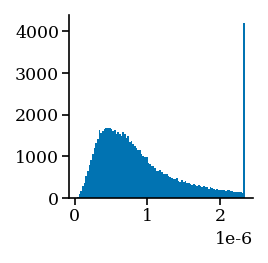

In [30]:
plt.hist(normalized_maps[0].flatten(), bins=100);

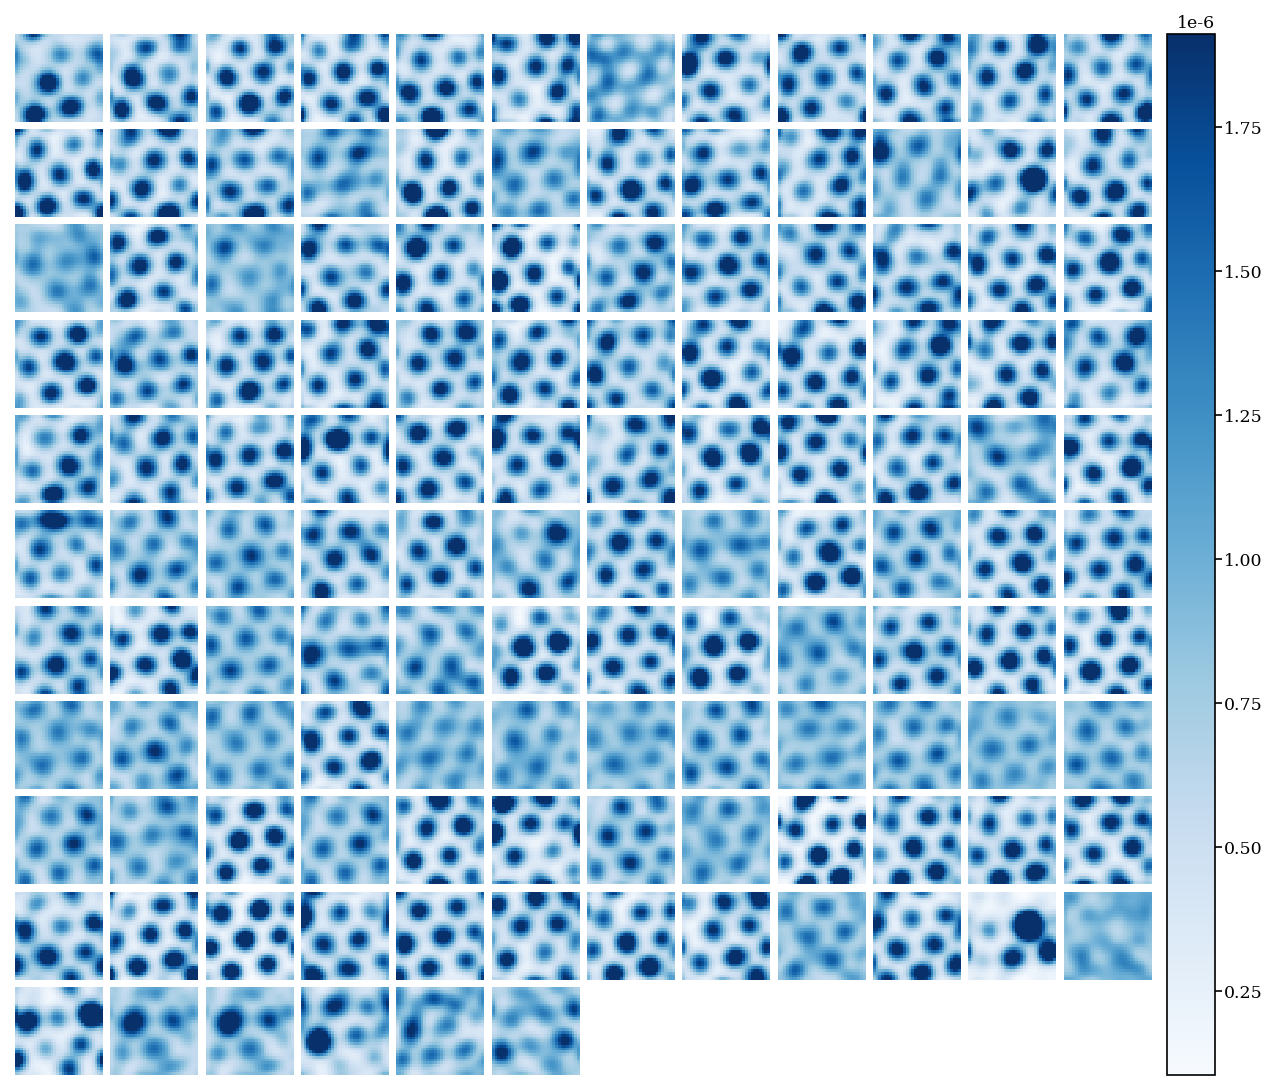

In [31]:
multiimshow(normalized_maps[2], figsize=(8,8), normalize=True, origin='lower');

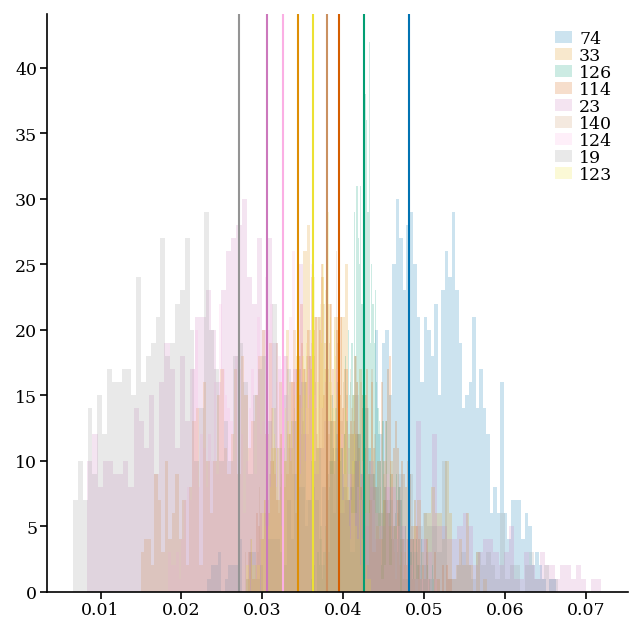

In [32]:
# plot 1d histogram of energy maps
fig, ax = plt.subplots(figsize=(5,5))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(len(energy_maps)):
    ax.hist(energy_maps_normalized[i].flatten(), bins=100, alpha=0.2, label=str(len(all_ratemaps[i])))
    ax.axvline(np.mean(energy_maps_normalized[i]), color=color_cycle[i])
ax.legend()

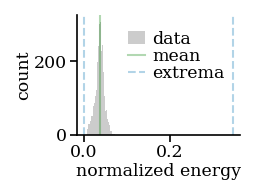

In [33]:
fig, ax = plt.subplots(figsize=(1.5, 1.1))
n, bins, _ = plt.hist(energy_maps_normalized.flatten(), bins=100, alpha=0.2, color='k', label='data')
max_bin = np.argmax(n)
mean_rate = np.mean(energy_maps_normalized.flatten())
min_rate = min([np.min(ratemaps) for ratemaps in all_ratemaps])
max_rate = max([np.max(ratemaps) for ratemaps in all_ratemaps])
#plt.axvline(bins[max_bin], color='r',alpha=0.3)
ax.axvline(mean_rate, color='g', alpha=0.3, label='mean')
ax.axvline(min_rate ,alpha=0.3, linestyle='--')
ax.axvline(max_rate, alpha=0.3, linestyle='--', label='extrema')
ax.legend()
ax.set_xlabel('normalized energy', fontsize='small')
ax.set_ylabel('count', fontsize='small')
fig.tight_layout(pad=0)
fig.savefig('./results/energy-histogram.pdf')

[ 74  33 126 114  23 140 124  19 123]


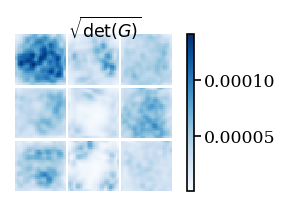

In [34]:
all_metric_components = np.array([metric_components_from_ratemaps(ratemaps) for ratemaps in all_ratemaps])
#all_metric_components = np.array([metric_components_from_ratemaps(ratemaps) for ratemaps in all_ratemaps_complete])
all_m11s = all_metric_components[:,0]
all_m22s = all_metric_components[:,1]
all_m12s = all_metric_components[:,2]
G = np.array([
    [all_m11s, all_m12s],
    [all_m12s, all_m22s],
]).transpose(2,3,4,0,1)
#det_G = np.sqrt(np.linalg.det(G))
det_G = np.sqrt(np.linalg.det(G))
ncells = np.array([len(ratemaps) for ratemaps in all_ratemaps])#[:,None,None]
print(ncells)
fig, axs = multiimshow(det_G, figsize=(1.2,1.2), normalize=True, origin='lower', axes_pad=0.02);
#multiimshow((det_G/np.sum(det_G,axis=(1,2),keepdims=True))-
#            (energy_maps[:,1:-1,1:-1]/np.sum(energy_maps[:,1:-1,1:-1],axis=(1,2),keepdims=True)), 
#            figsize=(5,5), normalize=True, origin='lower');

fig.suptitle(r'$\sqrt{\det(G)}$', fontsize='small')
fig.savefig('./results/experimental-detG.pdf', bbox_inches='tight')

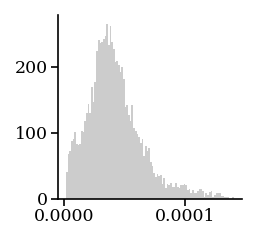

In [35]:
plt.hist(det_G.flatten(), bins=100, alpha=0.2, color='k');

In [36]:
rng = np.random.default_rng(seed=3)
scrambled_energy_maps = np.array([rng.permutation(energy_maps[i].flatten()).reshape(32,32) for i in range(len(energy_maps))])

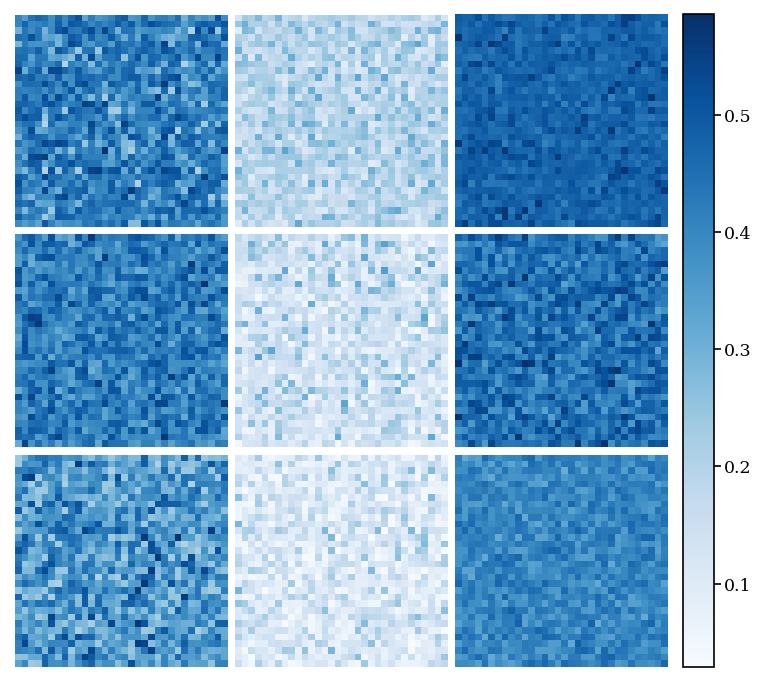

In [37]:
multiimshow(scrambled_energy_maps, figsize=(5,5), normalize=True, origin='lower');

In [38]:
#multiimshow(scrambled_det_G.reshape(-1,30,30), figsize=(5,5), normalize=True, origin='lower');

In [39]:
pearson_r = [np.corrcoef(det_G.reshape(-1,30**2)[i], energy_maps[:,1:-1,1:-1].reshape(-1,30**2)[i])[0,1] for i in range(len(det_G))]
#scrambled_pearson_r = [np.corrcoef(scrambled_det_G[i], scrambled_energy_maps[i])[0,1] for i in range(len(scrambled_det_G))]

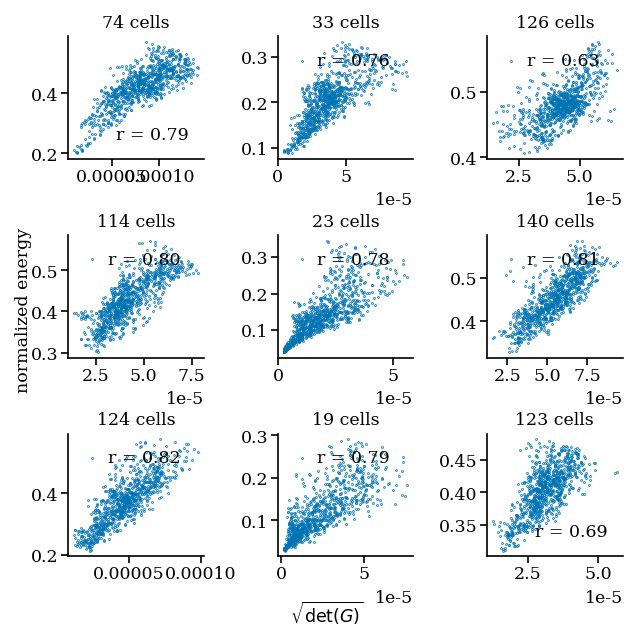

In [40]:
fig, axs = plt.subplots(ncols=3,nrows=3, figsize=(4,4))
for i in range(len(det_G)):
    ax = axs[i//3, i%3]
    ax.scatter(det_G[i].flatten(), energy_maps[i,1:-1,1:-1].flatten(), s=0.1, label=f'r = {pearson_r[i]:.2f}')
    ax.set_title(f'{ncells[i]} cells', fontsize='small')
    #ax.set_xlabel('det(G)', fontsize='small')
    #ax.set_ylabel('energy', fontsize='small')
    ax.legend()
#plt.scatter(det_G.flatten(), energy_maps[:,1:-1,1:-1].flatten())
#plt.xlabel('det(G)')
#plt.ylabel('energy')
# set common y label
fig.text(-0.02, 0.5, 'normalized energy', va='center', rotation='vertical', fontsize='small')
fig.text(0.5, -0.02, r'$\sqrt{\det(G)}$', ha='center', fontsize='small')

fig.tight_layout(pad=0.2)
fig.savefig('./results/experimental-detG-vs-energy.pdf', bbox_inches='tight')

In [41]:
"""
fig, axs = plt.subplots(ncols=3,nrows=3, figsize=(6,6))
for i in range(len(det_G)):
    ax = axs[i//3, i%3]
    ax.scatter(scrambled_det_G[i], scrambled_energy_maps[i], s=0.1, label=f'Pearson r = {scrambled_pearson_r[i]:.2f}')
    ax.set_title(f'{ncells[i]} cells')
    ax.set_xlabel('det(G)')
    ax.set_ylabel('energy')
    ax.legend()
fig.tight_layout(pad=0)
"""

"\nfig, axs = plt.subplots(ncols=3,nrows=3, figsize=(6,6))\nfor i in range(len(det_G)):\n    ax = axs[i//3, i%3]\n    ax.scatter(scrambled_det_G[i], scrambled_energy_maps[i], s=0.1, label=f'Pearson r = {scrambled_pearson_r[i]:.2f}')\n    ax.set_title(f'{ncells[i]} cells')\n    ax.set_xlabel('det(G)')\n    ax.set_ylabel('energy')\n    ax.legend()\nfig.tight_layout(pad=0)\n"

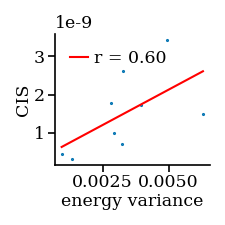

In [42]:
fig, ax = plt.subplots(figsize=(1.3,1.3))
energy_var = np.var(energy_maps, axis=(1,2))
ax.scatter(energy_var, data_cis)#, s=5)
# create linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(energy_var, data_cis)
x = np.linspace(min(energy_var), max(energy_var), 100)
y = slope*x + intercept
ax.plot(x, y, color='r', label=f'r = {r_value:.2f}')
ax.set_xlabel('energy variance', fontsize='small')
ax.set_ylabel('CIS', fontsize='small')
ax.legend()
fig.tight_layout(pad=0)
fig.savefig('./results/energy-variance-cis.pdf')

In [43]:
from models import JacobianCI
ci_model = JacobianCI(ncells=105,lr=1e-3)#, seed=3)
#loss_history = ci_model.train_model(ntrain_steps=1000)

In [44]:
import torch

radius = ci_model.unit_cell.radius*2


x = np.linspace(-radius,radius,res)
y = np.linspace(-radius,radius,res)
X,Y = np.meshgrid(x,y)
square_mesh = np.stack([X,Y],axis=-1)
square_mesh.shape

noise = np.random.normal(0,0.0001,size=(res**2,2))
ci_ratemaps = ci_model(torch.tensor(square_mesh.reshape(-1,2) + noise).float()).detach().numpy().T.reshape(-1,res,res)
#ci_ratemaps += np.random.normal(0,0.05,ci_ratemaps.shape)

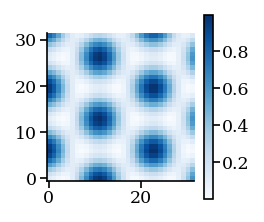

In [45]:
plt.imshow(ci_ratemaps[0], origin='lower')
plt.colorbar()

0.33860722 0.5159449


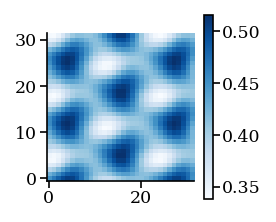

In [46]:
sub_select_maps = np.copy(ci_ratemaps)#[50:100])
ci_energy_maps = np.linalg.norm(sub_select_maps,axis=0)
ci_energy_maps = ci_energy_maps / np.sqrt(len(sub_select_maps))

plt.imshow(ci_energy_maps, origin='lower')
plt.colorbar()
print(ci_energy_maps.min(), ci_energy_maps.max())

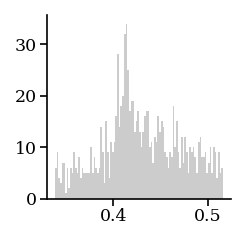

In [47]:
plt.hist(ci_energy_maps.flatten(), bins=100, alpha=0.2, color='k');